- Searches for all massive satellites of these halos and their time of entry 
- Searches for all massive progenitors and their time of entry.
- Massive progenitors are defined as those whose peak mass of the subhalo compared to the present day mass of the galaxy is greater than 0.05. mpeak_sub/dm_mw0>0.05 

In [2]:
import numpy as np
import scipy.stats
import h5py
import sys
import pickle
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
sys.path.insert(0,"../")
import illustris_python as il

In [3]:
from astropy.cosmology import FlatLambdaCDM

redshiftdata1=np.genfromtxt('data/redshift_TNG', dtype=[('snap','<i8'), ('redshift','<f8')])

def find_redshift(snap):
    if len(snap)==1:
        arg=np.where(redshiftdata1['snap']==snap)[0]
        if len(arg)>0:
            return redshiftdata1['redshift'][arg[0]]
    else:
        red=np.zeros_like(snap,dtype=float)
        for i in range(len(red)):
            arg=np.where(redshiftdata1['snap']==snap[i])[0]
            if len(arg)>0:
                red[i]=redshiftdata1['redshift'][arg[0]]
        return red
        
        
def redshift(scale):
    return 1.0/scale - 1.0

def find_scale(redshift):
    return 1.0/(redshift+1)

cosmo = FlatLambdaCDM(H0=67.74, Om0=0.3089)

def age(redshift):
    age1=cosmo.age(redshift)
    return 13.7 - age1.value

In [4]:
basePath = '/home/rdsouza/SIMS/TNG50/output/'

Find all MW-mass halos 

In [5]:
fields = ['SubhaloMassType','SubhaloFlag','SubhaloParent','SubhaloGrNr','SubhaloPos']
subhalos = il.groupcat.loadSubhalos(basePath, 99, fields=fields)

In [6]:
h0=0.6774
dm=subhalos['SubhaloMassType'][:,1]*1e10/h0
sm=subhalos['SubhaloMassType'][:,4]*1e10/h0
mask_sub=subhalos['SubhaloFlag'][:]
parent=subhalos['SubhaloParent'][:]
pos=subhalos['SubhaloPos'][:]/h0
GrpNo=subhalos['SubhaloGrNr'][:]

In [7]:
# Load the Group Catalog with information about which subhalos are centrals
groups = il.groupcat.loadHalos(basePath,99,fields=['GroupFirstSub','Group_M_Crit200'])
GroupFirstSub=groups['GroupFirstSub']
group_dm200  =groups['Group_M_Crit200']*1e10/h0

In [8]:
dm200=np.zeros_like(dm)
for i in range(len(dm200)):
    dm200[i]=group_dm200[GrpNo[i]]

In [10]:
# Select MW-mass central halos
mask_MW=np.load('data/MWM31SubfindID.npy')
ll_MW  = len(dm[mask_MW])

In [11]:
# Find all subhalos that belong to the first  MW halo.
MW_subhalo_ids=mask_MW
MW_subhalo_mass=dm200[mask_MW]

## Algorithm

- Create a large array to store the results of the mergers
- First find all the large progentiors which merged.
- Second find all the large satellites which are within the virial radius.
- We can distinguish the two scenarios with the last paramter in the array, True if merged, False if still around.

In [12]:
store_all=np.zeros(ll_MW*1000,dtype=[('SubfindID', '<i8'), ('SubhaloID','<i8'), ('mpeak', '<f8'), ('speak', '<f8'), ('SnapArrival','<i4'), ('Merg',np.bool)])
count_all=0

In [13]:
count_all=0
fields_tree = ['SubhaloID','MainLeafProgenitorID', 'FirstSubhaloInFOFGroupID','DescendantID','FirstProgenitorID','SubhaloMassType','SubfindID','SnapNum','SubhaloGrNr', 'Group_M_Crit200']
for i in range(ll_MW):
    subhaloid=MW_subhalo_ids[i]
    dm_mw=dm200[subhaloid]
    # get mpb of the MW profile
    tree1 = il.sublink.loadTree(basePath, 99, subhaloid, fields=fields_tree)
    arg_mpb=np.where((tree1['SubhaloID'][:]>=tree1['SubhaloID'][0]) & (tree1['SubhaloID'][:]<=tree1['MainLeafProgenitorID'][0]))[0]   
    subhaloid_mpb          = tree1['SubhaloID'][arg_mpb]
    subhaloid_mpb_snap     = tree1['SnapNum'][arg_mpb]
    subhaloid_mpb_mass200  = tree1['Group_M_Crit200'][arg_mpb]*1e10 / h0
    
    # Find which subhalos are part of the group or not. 
    # The hidden assumption is that everything in the mpb is the first subhalo in the fof group.
    
    subhaloid_mpb_firstsubhalo=tree1['FirstSubhaloInFOFGroupID'][arg_mpb]
    mask_grp=np.in1d(tree1['FirstSubhaloInFOFGroupID'][:],subhaloid_mpb_firstsubhalo)
    subhalosids_grp_in=tree1['SubhaloID'][mask_grp]
    subhalosids_grp_out=tree1['SubhaloID'][~mask_grp]
    
    # Find those that just fell in.
    mask_just_fell_in= np.in1d(tree1['DescendantID'][~mask_grp],subhalosids_grp_in)
    subhalosids_firstinfall=subhalosids_grp_out[mask_just_fell_in]
    mask_first_infall=np.zeros_like(tree1['SubhaloID'][:],dtype=np.bool)
    for j in range(len(subhalosids_firstinfall)):
        arg1=np.where(tree1['SubhaloID'][:]==subhalosids_firstinfall[j])[0]
        mask_first_infall[arg1]=True

    # Apply a mass cut for the subhalos that fell in
    mask_first_infall= mask_first_infall & ((tree1['SubhaloMassType'][:,1] * 1e10 / h0)>1e8)
    arg1=np.where(mask_first_infall)[0]
    # information about these subhalos which fell in
    subhalosids_firstinfall=tree1['SubhaloID'][mask_first_infall]
    snap_firstinfall=tree1['SnapNum'][mask_first_infall]
    subhalosids_firstinfall_mpeak=np.zeros_like(subhalosids_firstinfall,dtype=float)
    subhalosids_firstinfall_speak=np.zeros_like(subhalosids_firstinfall,dtype=float)
    mask_subhalosids_firstinfall=np.ones_like(subhalosids_firstinfall,dtype=bool)
    # create a mask - check for mass, but also check for previous entry.
    # note that the mask considers everything True in the beginning
    for j in range(len(arg1)):
        ii=arg1[j]
        #if (tree1['SnapNum'][ii]<=25):
        #    mask_subhalosids_firstinfall[j]=False 
        #    continue
        arg_sub_mpb=np.where((tree1['SubhaloID'][:]>=tree1['SubhaloID'][ii]) & (tree1['SubhaloID'][:]<=tree1['MainLeafProgenitorID'][ii]))[0]  
        subhalosids_sub=tree1['SubhaloID'][arg_sub_mpb]
        subhalosids_firstinfall_mpeak[j] = np.max(tree1['SubhaloMassType'][arg_sub_mpb,1] * 1e10 / h0)
        #subhalosids_firstinfall_mpeak[j] = np.max(tree1['Group_M_Crit200'][arg_sub_mpb] * 1e10 / h0)
        subhalosids_firstinfall_speak[j] = np.max(tree1['SubhaloMassType'][arg_sub_mpb,4] * 1e10 / h0)
        
        #arg_inter_mpb=np.where(subhaloid_mpb_mass200<=tree1['SnapNum'][ii])[0]
        #if len(arg_inter_mpb)<1:
        #    mask_subhalosids_firstinfall[j]=False 
        #    continue
        #dm_mw_inter=np.max(subhaloid_mpb_mass200[arg_inter_mpb])
        if subhalosids_firstinfall_mpeak[j]/dm_mw<0.05:
            mask_subhalosids_firstinfall[j]=False
            continue
        mask_doublefall=np.in1d(subhalosids_firstinfall,subhalosids_sub)
        arg_check=np.where(subhalosids_firstinfall[mask_doublefall])[0]
        # one also finds oneself in the list.
        if len(arg_check)>1:
            arg_snap_check=np.where(snap_firstinfall[mask_doublefall]<  snap_firstinfall[j])[0]
            if len(arg_snap_check)>0: 
                mask_subhalosids_firstinfall[j]=False
            
            
                
    subhalosids_firstinfall = subhalosids_firstinfall[mask_subhalosids_firstinfall]
    subhalosids_firstinfall_mpeak=subhalosids_firstinfall_mpeak[mask_subhalosids_firstinfall]
    subhalosids_firstinfall_speak=subhalosids_firstinfall_speak[mask_subhalosids_firstinfall]
    snap_firstinfall=snap_firstinfall[mask_subhalosids_firstinfall]
    for j in range(len(subhalosids_firstinfall_mpeak)):
        store_all['SubfindID'][count_all]=subhaloid
        store_all['SubhaloID'][count_all]=subhalosids_firstinfall[j]
        store_all['mpeak'][count_all]=subhalosids_firstinfall_mpeak[j]
        store_all['speak'][count_all]=subhalosids_firstinfall_speak[j]
        store_all['SnapArrival'][count_all]=snap_firstinfall[j]
        store_all['Merg'][count_all]=True
        count_all=count_all+1
    #print(subhaloid, np.log10(dm_mw), len(subhalosids_firstinfall_mpeak))


In [14]:
count_all

228

In [15]:
fields_tree = ['SubhaloID','SubhaloMassType','SubfindID','SnapNum','SubhaloGrNr','Group_M_Crit200']
for i in range(ll_MW):
    subhaloid=MW_subhalo_ids[i]
    dm_mw0   = dm[subhaloid]
    tree1   = il.sublink.loadTree(basePath, 99, subhaloid, fields=fields_tree, onlyMPB=True)
    grpno_mw   = tree1['SubhaloGrNr'][:]
    snapno_mw  = tree1['SnapNum'][:]
    dm_mw      = tree1['Group_M_Crit200'][:]*1e10 / h0
    ll_snap=len(snapno_mw)
    arg_sub=np.where((GrpNo==GrpNo[subhaloid]) & mask_sub  & (dm>1e8))[0]
    for arg1 in arg_sub:
        if arg1!=subhaloid:
            tree2 = il.sublink.loadTree(basePath, 99, arg1, fields=fields_tree, onlyMPB=True)
            mpeak_sub = np.max(tree2['SubhaloMassType'][:,1] * 1e10 / h0)
            speak_sub = np.max(tree2['SubhaloMassType'][:,4] * 1e10 / h0)
            #m200_sub  = np.max(tree2['Group_M_Crit200']*1e10/h0)
            grpno_sub=tree2['SubhaloGrNr'][:]
            snapno_sub=tree2['SnapNum'][:]
            snap_arrival=99
            for i in range(ll_snap):
                arg_snap=np.where(snapno_sub==snapno_mw[i])[0]
                if len(arg_snap)>0:
                    if grpno_mw[i]==grpno_sub[arg_snap[0]]:
                            snap_arrival=snapno_mw[i]
            
            arg_inter_mpb=np.where(snapno_mw<=snap_arrival)[0]
            if len(arg_inter_mpb)>1:
                dm_mw_inter=np.max(dm_mw[arg_inter_mpb])
                if mpeak_sub/dm_mw0>0.05:
                    store_all['SubfindID'][count_all]=subhaloid
                    store_all['SubhaloID'][count_all]=tree2['SubhaloID'][0]
                    store_all['mpeak'][count_all]=mpeak_sub
                    store_all['speak'][count_all]=speak_sub
                    store_all['SnapArrival'][count_all]=snap_arrival
                    store_all['Merg'][count_all]=False
                    count_all=count_all+1
    #print(subhaloid,np.log10(dm[subhaloid]*1e10),count)

In [16]:
count_all

386

In [17]:
mask=store_all['SubfindID'][:]>0
store_all=store_all[mask]
np.save('data/ans_TNG50.npy',store_all)

In [18]:
print(store_all)

[(402555,         151381088, 1.55287388e+11, 2.66157286e+09, 36,  True)
 (428177, 10000002000039818, 3.45614451e+11, 1.47302554e+10, 38,  True)
 (434356, 10000001900117544, 4.99836912e+11, 2.76022211e+10, 58,  True)
 (435752,         155630302, 2.20274295e+11, 9.36910029e+09, 42,  True)
 (435752,         155687526, 4.38009856e+11, 1.41524644e+10, 42,  True)
 (436932,          55336096, 1.60006816e+11, 2.96577408e+09, 34,  True)
 (440407, 10000001700097057, 3.83768592e+11, 1.29276703e+10, 64,  True)
 (443049,         130958375, 1.66059344e+11, 3.02611942e+09, 39,  True)
 (443049,         130981777, 1.47799228e+11, 1.38441024e+09, 40,  True)
 (445626,          87519652, 2.51943518e+11, 1.31271025e+10, 36,  True)
 (445626,          87552636, 1.66571164e+11, 6.97767066e+09, 40,  True)
 (446665,         164107194, 1.22749247e+11, 1.39949990e+09, 26,  True)
 (446665,         164130771, 1.51791731e+11, 2.86279859e+09, 37,  True)
 (446665,         164167158, 9.24426322e+10, 2.33145754e+09, 46,

(array([11., 11., 11., 14., 14., 17., 23., 12., 15., 30.]),
 array([38., 44., 50., 56., 62., 68., 74., 80., 86., 92., 98.]),
 <a list of 10 Patch objects>)

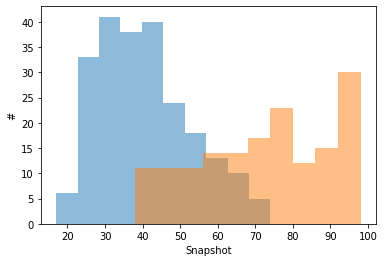

In [20]:
# tests
plt.xlabel('Snapshot')
plt.ylabel('#')
plt.hist(store_all['SnapArrival'][store_all['Merg']==True], alpha=0.5)
plt.hist(store_all['SnapArrival'][store_all['Merg']==False], alpha=0.5)

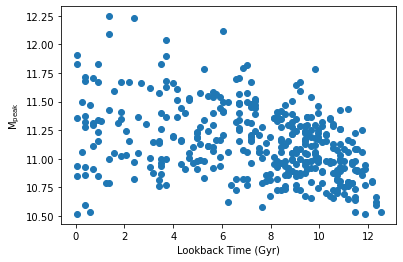

In [21]:
plt.xlabel('Lookback Time (Gyr)')
plt.ylabel('$\mathrm{M_{peak}}$')
plt.scatter(age(find_redshift(store_all['SnapArrival'][:])),np.log10(store_all['mpeak'][:]))

Text(0, 0.5, '#')

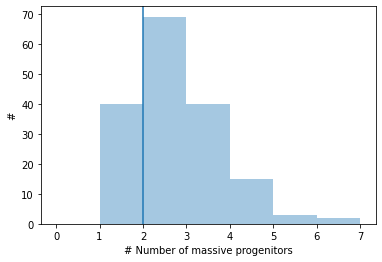

In [26]:
# Average number of massive progenitors per MW-mass halo
a,b=np.unique(store_all['SubfindID'][:],return_counts=True)
plt.hist(b, bins=np.arange(8), alpha=0.4)
plt.axvline(np.median(b))
plt.xlabel('# Number of massive progenitors')
plt.ylabel("#")

In [72]:
arg=np.where(store_all['SubfindID']==454171)[0]
print(store_all[arg])

[(454171, 10000000202497808, 1.24320888e+12, 5.70025329e+10, 90, False)]


In [66]:
age(find_redshift(np.array([55,])))

7.008151235452507

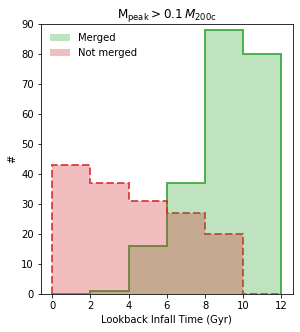

In [28]:
maskMerg   = (store_all['Merg']==True)
maskNoMerg = (store_all['Merg']==False)
S_age=age(find_redshift(store_all['SnapArrival']))
fig1=plt.figure(figsize=(5.,5.))
ax1 = fig1.add_axes([0.15, 0.15, 0.7, 0.75])
bins=np.arange(0,14,2)
ax1.hist(S_age[maskMerg],bins=bins, alpha=0.8, histtype='step', color='C2',lw=2)
ax1.hist(S_age[maskNoMerg],bins=bins, alpha=0.8,histtype='step', color='C3',lw=2, linestyle='--')
ax1.hist(S_age[maskMerg],bins=bins, color='C2', alpha=0.3, label='Merged')
ax1.hist(S_age[maskNoMerg],bins=bins, color='C3', alpha=0.3, label='Not merged')
ax1.set_xticks([0,2,4,6,8,10,12])
ax1.set_xlabel('Lookback Infall Time (Gyr)')
ax1.set_ylabel('#')
ax1.set_title(r'$\mathrm{M_{peak}}> 0.1\, M_{200\mathrm{c}}$')
ax1.set_ylim([0,90])

leg1=plt.legend(loc=2)
leg1.get_frame().set_linewidth(0.0)